In [1]:
import seaborn as sns
from sklearn.datasets import fetch_covtype
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.naive_bayes import GaussianNB
import pandas as pd

# Carregar o dataset
print("Carregando o dataset 'Covertype'...\n")
data = fetch_covtype(as_frame=True)
description_data = fetch_covtype()

# Exibir descrição da base
print("Descrição do Dataset:\n")
print(description_data.DESCR)  #

# Separar variáveis e classes
X = data.data
y = data.target

# Mostrar as classes presentes no target
print("\nClasses (Tipos de Cobertura Florestal):\n")
print("Valores únicos encontrados na variável de saída (y):", sorted(y.unique()))
print(f"Total de classes distintas: {len(y.unique())}")

# Listar as features disponíveis
print("\nLista de Features Disponíveis no Dataset:\n")
for i, feature in enumerate(X.columns, 1):
    print(f"{i:2}. {feature}")

Carregando o dataset 'Covertype'...

Descrição do Dataset:

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

=================   ============
Classes                        7
Samples total             581012
Dimensionality                54
Features                     int
=================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target

In [2]:
features_continuas = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
    'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]

print("Variáveis Contínuas Selecionadas (10):")
for i, feat in enumerate(features_continuas, 1):
    print(f"{i}. {feat}")

features_binarias = [col for col in X.columns if col not in features_continuas]

print(f"\nVariáveis Binárias Detectadas ({len(features_binarias)}):")
for i, feat in enumerate(features_binarias, 1):
    print(f"{i}. {feat}")

# Resumo estatístico antes e depois da normalização
X_cont = X[features_continuas]
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_cont)
X_norm_df = pd.DataFrame(X_norm, columns=features_continuas)

print("\nResumo Estatístico das Variáveis Contínuas — Original vs. Normalizado:")
print("""
Objetivo: comparar estatísticas descritivas (média, desvio padrão, mínimo, máximo) antes e depois da normalização.

→ O método .describe() mostra essas estatísticas por variável.
→ Isso é útil para verificar o efeito da transformação e confirmar que a normalização foi aplicada corretamente.
""")

summary_before = X_cont.describe().T[['mean', 'std', 'min', 'max']]
summary_after = X_norm_df.describe().T[['mean', 'std', 'min', 'max']]
summary_combined = pd.concat([
    summary_before.rename(columns=lambda x: f'{x}_original'),
    summary_after.rename(columns=lambda x: f'{x}_normalizado')
], axis=1)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

print(summary_combined.round(2))

print("""
Justificativa para Separar e Normalizar:
- As variáveis contínuas possuem escalas diferentes (ex: 'Elevation' varia de centenas a milhares; 'Aspect' vai até 360).
- O Naive Bayes Gaussiano assume que as variáveis seguem uma distribuição normal com média 0 e desvio padrão 1 para cada classe.
- A normalização (z-score) ajuda a aproximar essa suposição, melhorando o desempenho e a robustez do modelo.
- Já as variáveis binárias (0 ou 1) não precisam ser transformadas — elas já estão em escala adequada e sua distribuição é discreta.
- Normalizar evita que variáveis com escala maior dominem a probabilidade total calculada pelo Naive Bayes.
""")

Variáveis Contínuas Selecionadas (10):
1. Elevation
2. Aspect
3. Slope
4. Horizontal_Distance_To_Hydrology
5. Vertical_Distance_To_Hydrology
6. Horizontal_Distance_To_Roadways
7. Hillshade_9am
8. Hillshade_Noon
9. Hillshade_3pm
10. Horizontal_Distance_To_Fire_Points

Variáveis Binárias Detectadas (44):
1. Wilderness_Area_0
2. Wilderness_Area_1
3. Wilderness_Area_2
4. Wilderness_Area_3
5. Soil_Type_0
6. Soil_Type_1
7. Soil_Type_2
8. Soil_Type_3
9. Soil_Type_4
10. Soil_Type_5
11. Soil_Type_6
12. Soil_Type_7
13. Soil_Type_8
14. Soil_Type_9
15. Soil_Type_10
16. Soil_Type_11
17. Soil_Type_12
18. Soil_Type_13
19. Soil_Type_14
20. Soil_Type_15
21. Soil_Type_16
22. Soil_Type_17
23. Soil_Type_18
24. Soil_Type_19
25. Soil_Type_20
26. Soil_Type_21
27. Soil_Type_22
28. Soil_Type_23
29. Soil_Type_24
30. Soil_Type_25
31. Soil_Type_26
32. Soil_Type_27
33. Soil_Type_28
34. Soil_Type_29
35. Soil_Type_30
36. Soil_Type_31
37. Soil_Type_32
38. Soil_Type_33
39. Soil_Type_34
40. Soil_Type_35
41. Soil_Type_3

Bloco de Análise Exploratória

=== Histogramas Antes e Depois da Normalização ===

Objetivo: comparar a distribuição de cada variável contínua antes e depois da normalização.

→ A normalização é fundamental para a melhora do desempenho do Naive Bayes (gaussiano), que assume distribuição normal nas features.



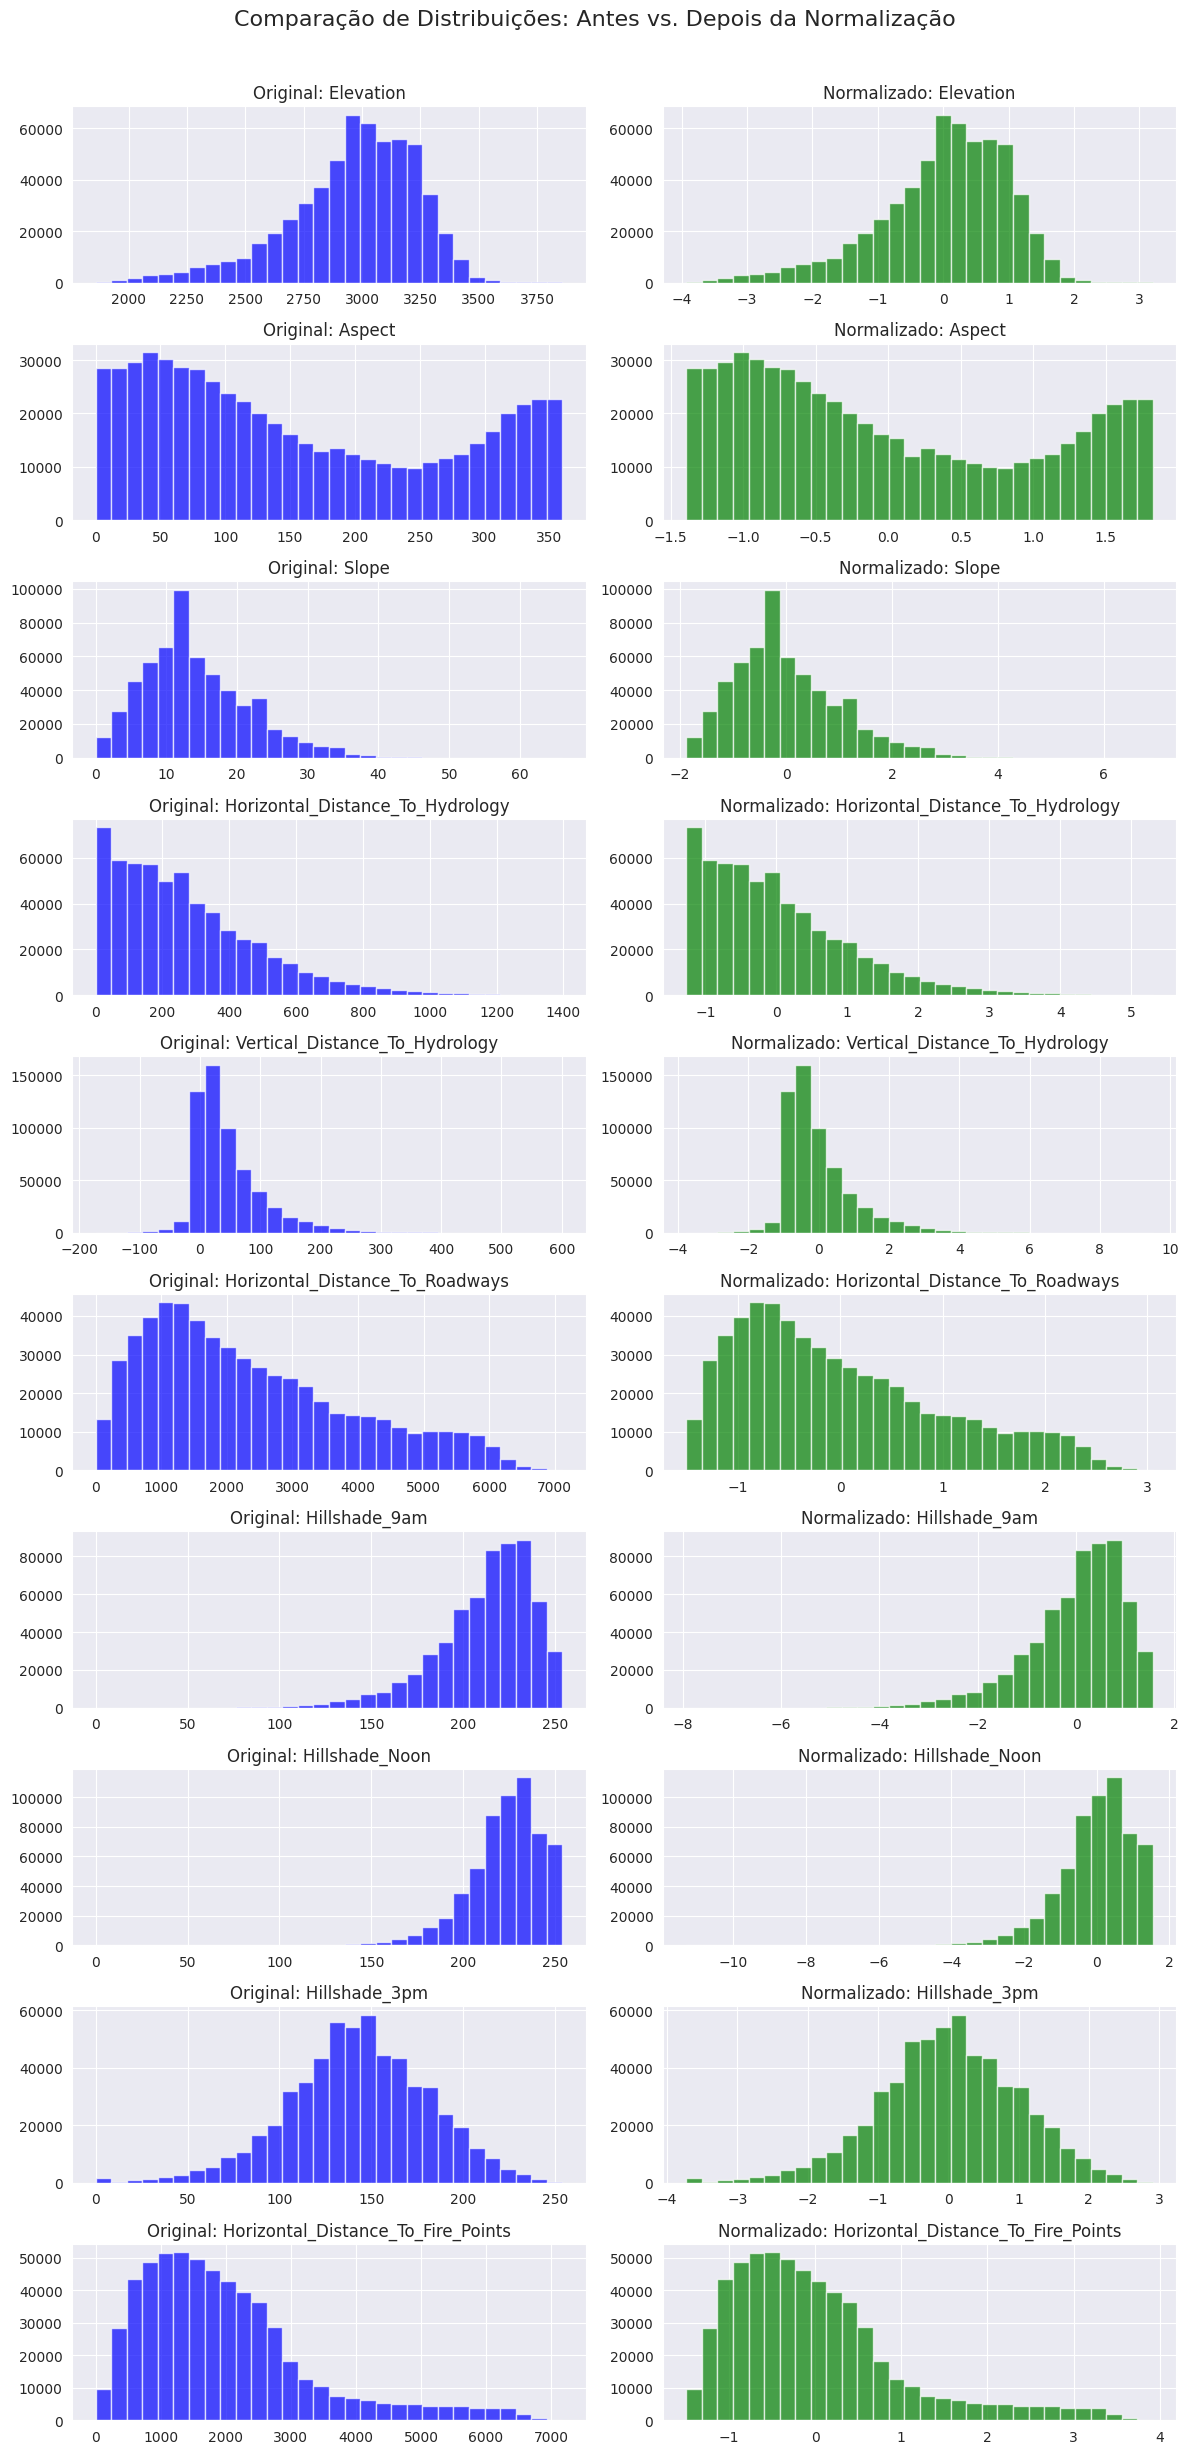

=== Histograma por Classe ===

Objetivo: visualizar como cada variável contínua se distribui entre as diferentes classes (tipos de cobertura florestal).

→ Se as curvas estiverem bem separadas por classe, a variável pode ajudar o modelo.
→ Se houver muita sobreposição entre as cores, essa variável tem baixo poder discriminativo.



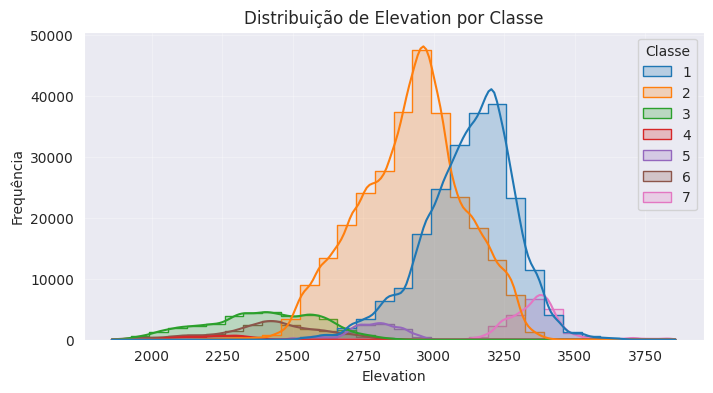

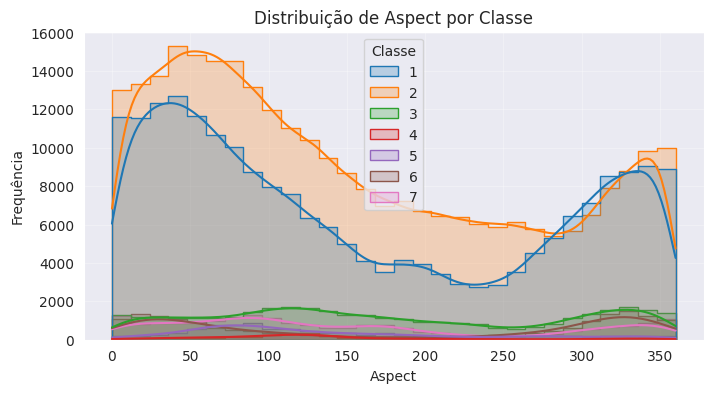

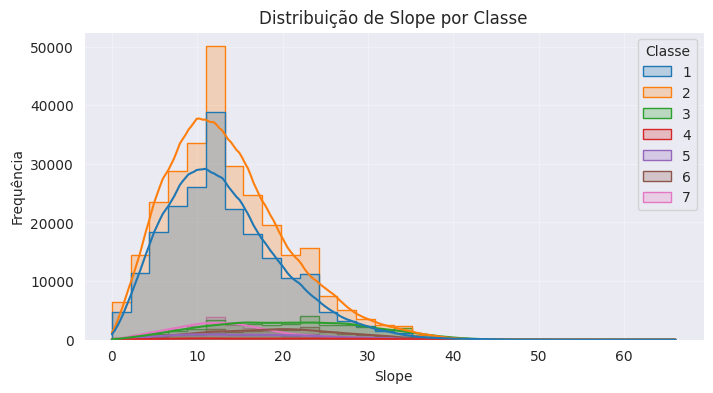

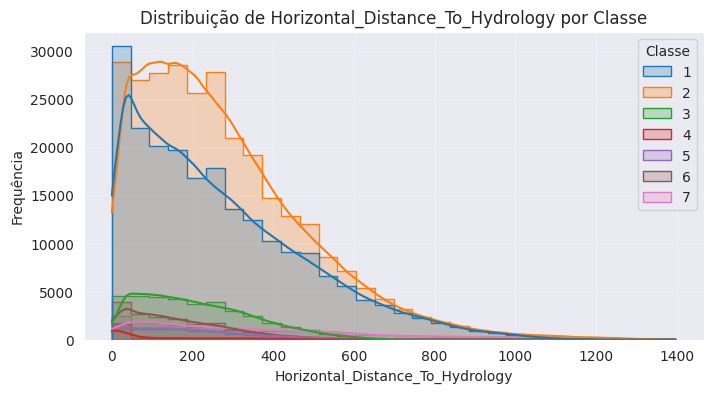

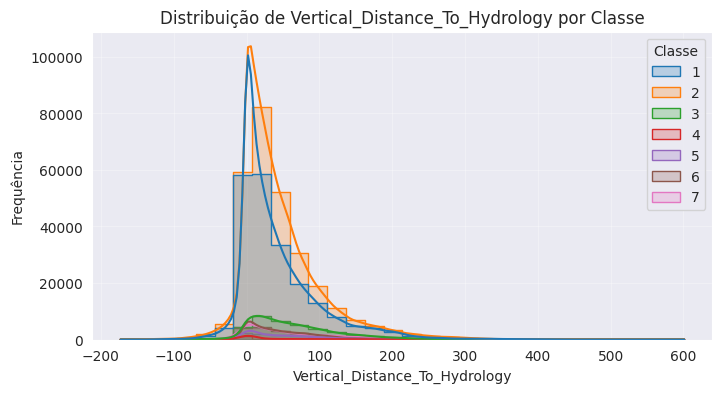

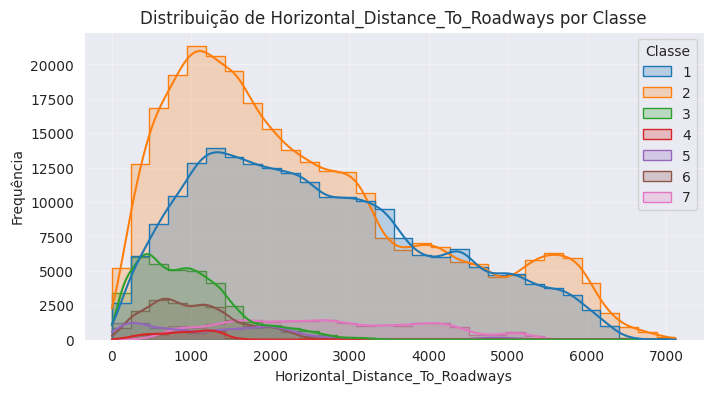

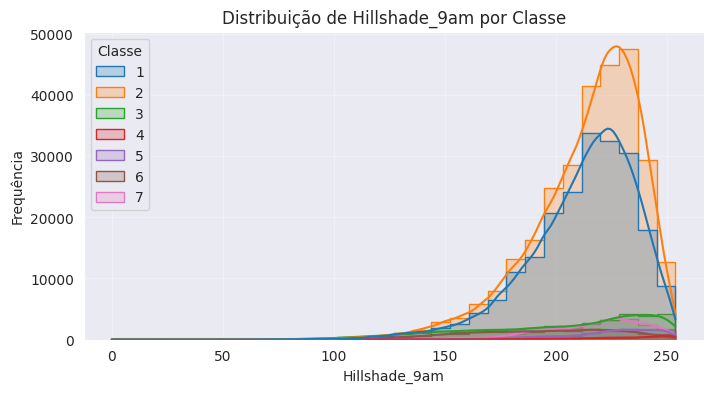

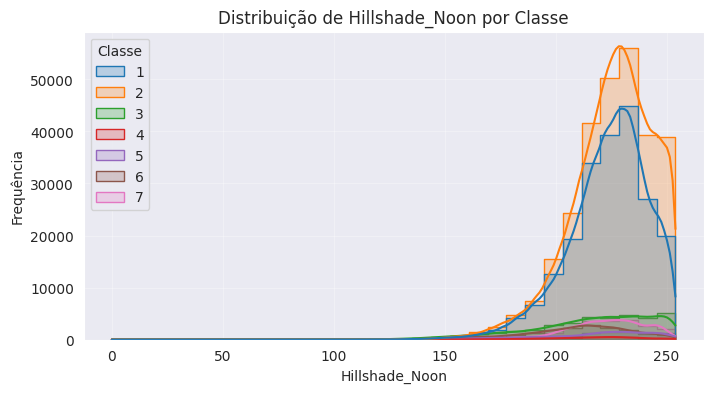

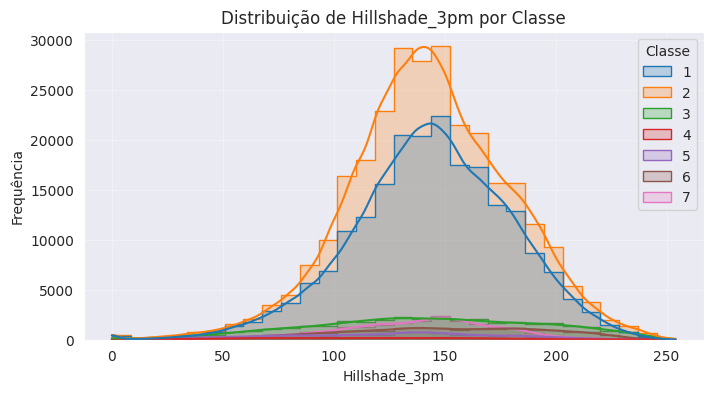

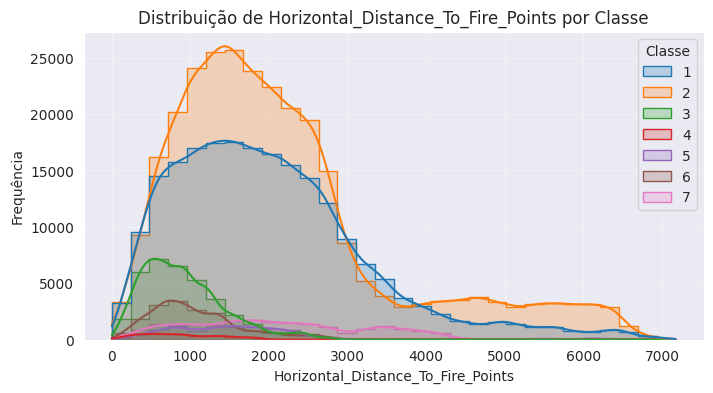


 Contour Plot — Distribuições e Fronteiras de Decisão do Naive Bayes

Objetivo: visualizar como o Naive Bayes toma decisões em 2D, considerando duas variáveis contínuas.

Variáveis escolhidas:
→ Elevation — Altitude do terreno (Elevation)
→ Slope — Inclinação do terreno (Slope)

Por que isso é útil?
- Permite enxergar as fronteiras de decisão aprendidas pelo Naive Bayes.
- Destaca onde há sobreposição entre classes.
- Ajuda a explicar visualmente possíveis erros do modelo.



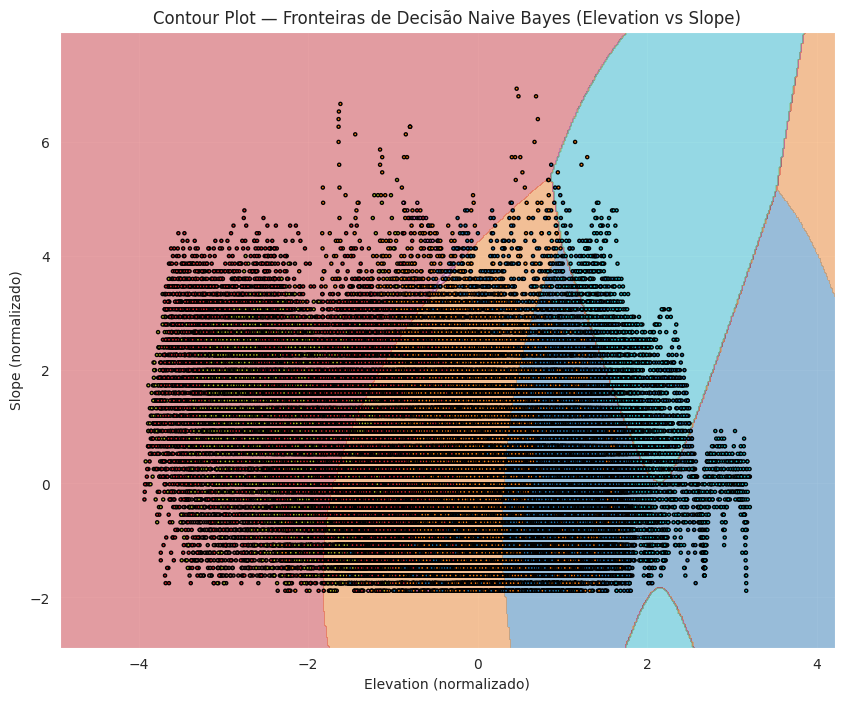


Interpretação:
- As regiões coloridas indicam como o Naive Bayes classifica novos pontos.
- As fronteiras podem parecer "suaves" devido à suposição de distribuição Gaussiana para cada classe.
- Sobreposições visíveis (pontos de diferentes classes na mesma região) explicam os erros do modelo.



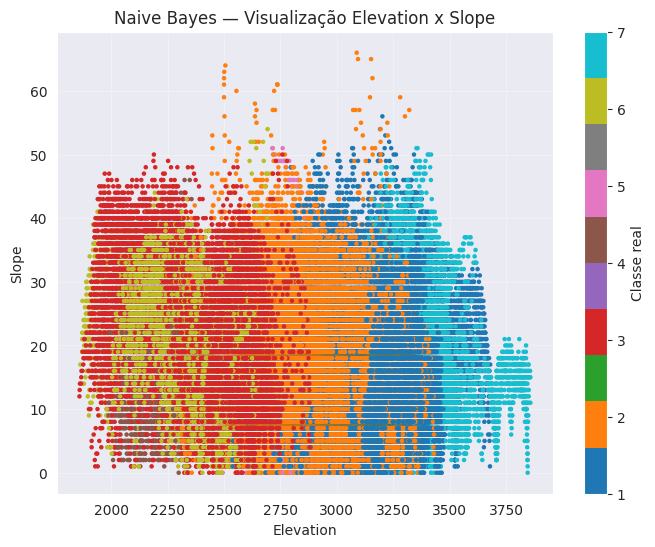

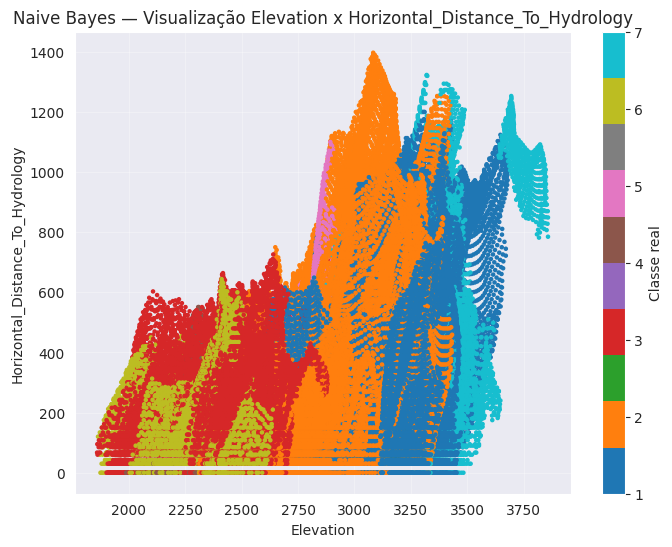

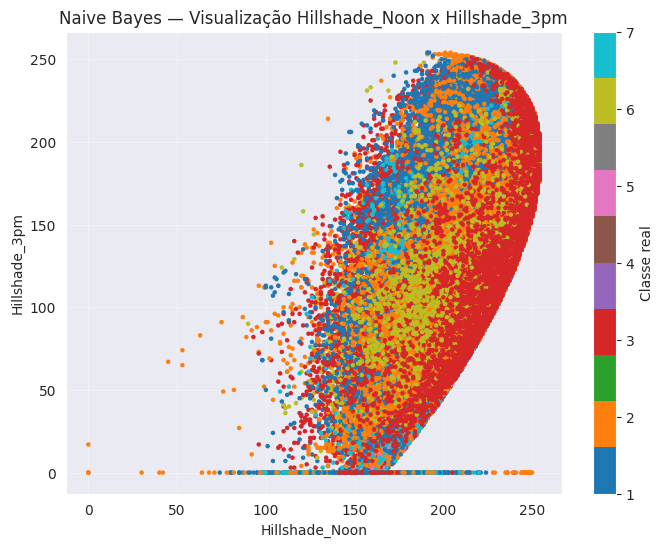

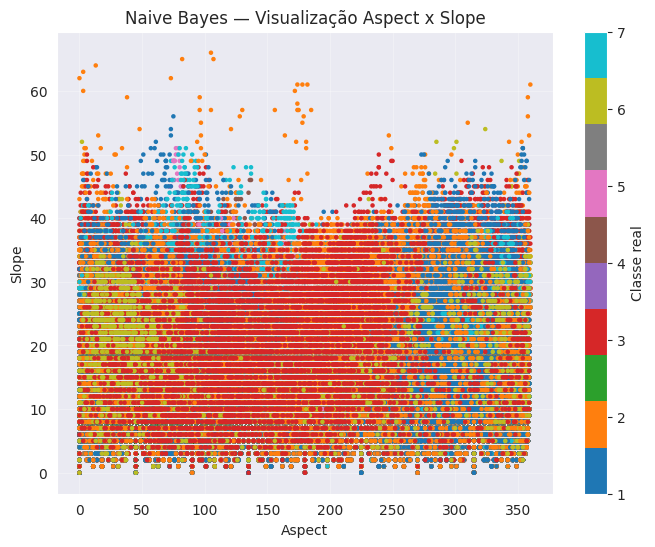


Essas visualizações ajudam a identificar regiões de sobreposição entre classes.
Isso é útil para entender onde o Naive Bayes pode falhar, já que ele assume independência entre variáveis.


PCA 2D — Usando Todas as 54 Variáveis

Objetivo: visualizar a distribuição geral das classes após reduzir a base de 54 para 2 dimensões via PCA.



In [ ]:
print("Bloco de Análise Exploratória\n")

print("=== Histogramas Antes e Depois da Normalização ===")
print("""
Objetivo: comparar a distribuição de cada variável contínua antes e depois da normalização.

→ A normalização é fundamental para a melhora do desempenho do Naive Bayes (gaussiano), que assume distribuição normal nas features.
""")

fig, axes = plt.subplots(len(features_continuas), 2, figsize=(12, len(features_continuas)*2.5))
fig.suptitle('Comparação de Distribuições: Antes vs. Depois da Normalização', fontsize=16)

for i, feature in enumerate(features_continuas):
    axes[i, 0].hist(X_cont[feature], bins=30, color='blue', alpha=0.7)
    axes[i, 0].set_title(f'Original: {feature}')
    axes[i, 1].hist(X_norm_df[feature], bins=30, color='green', alpha=0.7)
    axes[i, 1].set_title(f'Normalizado: {feature}')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print("=== Histograma por Classe ===")
print("""
Objetivo: visualizar como cada variável contínua se distribui entre as diferentes classes (tipos de cobertura florestal).

→ Se as curvas estiverem bem separadas por classe, a variável pode ajudar o modelo.
→ Se houver muita sobreposição entre as cores, essa variável tem baixo poder discriminativo.
""")

for feature in features_continuas:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=X.assign(Classe=y), x=feature, hue='Classe', kde=True, bins=30, palette='tab10', element='step')
    plt.title(f'Distribuição de {feature} por Classe')
    plt.xlabel(feature)
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    plt.show()

f1 = 'Elevation'
f2 = 'Slope'

print("\n Contour Plot — Distribuições e Fronteiras de Decisão do Naive Bayes")
print(f"""
Objetivo: visualizar como o Naive Bayes toma decisões em 2D, considerando duas variáveis contínuas.

Variáveis escolhidas:
→ {f1} — Altitude do terreno (Elevation)
→ {f2} — Inclinação do terreno (Slope)

Por que isso é útil?
- Permite enxergar as fronteiras de decisão aprendidas pelo Naive Bayes.
- Destaca onde há sobreposição entre classes.
- Ajuda a explicar visualmente possíveis erros do modelo.
""")

# Selecionar duas features contínuas
f1 = 'Elevation'
f2 = 'Slope'

X_2d = X[[f1, f2]]

# Normalizar as duas variáveis (necessário para o Naive Bayes Gaussiano)
scaler_2d = StandardScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)

# Treinar modelo Naive Bayes somente nessas duas dimensões
model_2d = GaussianNB()
model_2d.fit(X_2d_scaled, y)

# Gerar grade para visualizar as regiões de decisão
x_min, x_max = X_2d_scaled[:, 0].min() - 1, X_2d_scaled[:, 0].max() + 1
y_min, y_max = X_2d_scaled[:, 1].min() - 1, X_2d_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot com as regiões de decisão e os pontos reais
plt.figure(figsize=(10, 8))
cmap = ListedColormap(sns.color_palette("tab10").as_hex())
plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)  # Regiões
plt.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y, cmap=cmap, edgecolor='k', s=5)  # Dados reais
plt.title(f'Contour Plot — Fronteiras de Decisão Naive Bayes ({f1} vs {f2})')
plt.xlabel(f'{f1} (normalizado)')
plt.ylabel(f'{f2} (normalizado)')
plt.grid(True, alpha=0.3)
plt.show()

print("""
Interpretação:
- As regiões coloridas indicam como o Naive Bayes classifica novos pontos.
- As fronteiras podem parecer "suaves" devido à suposição de distribuição Gaussiana para cada classe.
- Sobreposições visíveis (pontos de diferentes classes na mesma região) explicam os erros do modelo.
""")

# Scatter plots entre pares de features para análise visual
feature_pairs = [
    ('Elevation', 'Slope'),
    ('Elevation', 'Horizontal_Distance_To_Hydrology'),
    ('Hillshade_Noon', 'Hillshade_3pm'),
    ('Aspect', 'Slope')
]

for f1, f2 in feature_pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(X[f1], X[f2], c=y, cmap='tab10', s=5)
    plt.colorbar(label='Classe real')
    plt.title(f'Naive Bayes — Visualização {f1} x {f2}')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.grid(True, alpha=0.3)
    plt.show()

print("""
Essas visualizações ajudam a identificar regiões de sobreposição entre classes.
Isso é útil para entender onde o Naive Bayes pode falhar, já que ele assume independência entre variáveis.

""")

print("PCA 2D — Usando Todas as 54 Variáveis\n")
print("Objetivo: visualizar a distribuição geral das classes após reduzir a base de 54 para 2 dimensões via PCA.\n")

scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)

pca_full = PCA(n_components=2)
X_pca_full = pca_full.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca_full[:, 0], X_pca_full[:, 1], c=y, cmap='tab10', s=5)
plt.colorbar(label='Classe Real')
plt.title('PCA 2D — Todas as Features (54 dimensões)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True, alpha=0.5)
plt.show()

print("PCA 2D — Somente com as 10 Variáveis Contínuas\n")
print("Objetivo: remover o ruído das variáveis binárias e destacar padrões mais claros entre as classes.\n")

X_continuas = X[features_continuas]

scaler_cont = StandardScaler()
X_cont_scaled = scaler_cont.fit_transform(X_continuas)

pca_cont = PCA(n_components=2)
X_pca_cont = pca_cont.fit_transform(X_cont_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca_cont[:, 0], X_pca_cont[:, 1], c=y, cmap='tab10', s=5)
plt.colorbar(label='Classe Real')
plt.title('PCA 2D — Apenas Variáveis Contínuas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.5)
plt.show()

print("""
Excluímos as 44 variáveis binárias (Wilderness e Soil_Type) porque têm baixa variabilidade (0 ou 1).
Isso pode distorcer a análise visual no PCA.
""")

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

print("\nEtapa: Preparando o Pré-Processador com ColumnTransformer")
print("""
Justificativa:
- O Naive Bayes Gaussiano (GaussianNB) assume que cada variável (feature) segue uma distribuição normal (Gaussiana) dentro de cada classe.
- Isso vale para variáveis contínuas. Por isso, aplicamos padronização (z-score) nelas para que tenham média ≈ 0 e desvio padrão ≈ 1.
- As variáveis binárias (0 ou 1) já estão em escala adequada e **não precisam ser normalizadas**.
""")

# Normalizar apenas as variáveis contínuas
preprocessador = ColumnTransformer([
    ('escala_continua', StandardScaler(), features_continuas)
], remainder='passthrough')

print("\nEtapa: Dividindo os Dados em Treino e Teste (80% / 20%)")
print("""
Justificativa:
- O split é feito com estratificação para preservar a proporção de cada classe nos dois conjuntos.
- Isso é importante em conjuntos desbalanceados, como o Covertype.
""")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nEtapa: Construindo a Pipeline com Pré-processador + GaussianNB")
print("""
Justificativa:
- Usamos a `Pipeline` para garantir que a padronização (z-score) seja aplicada corretamente e **somente aos dados de treino**.
- Isso evita *data leakage* e facilita a reutilização do pipeline com validação cruzada ou produção.
- O classificador escolhido é o **Naive Bayes Gaussiano (GaussianNB)**.

Por que usamos o GaussianNB?
- Porque nosso dataset contém **variáveis contínuas** que se beneficiam da suposição de distribuição Gaussiana.
- Embora tenhamos também **variáveis binárias (0 ou 1)**, o GaussianNB ainda pode lidar com elas, mesmo que **não seja o ideal**.
- Talvez poderiamos ter trocado por **BernoulliNB**.

Observação sobre as variáveis binárias:
- Idealmente, variáveis binárias poderiam ser tratadas com **BernoulliNB**, que é mais apropriado para dados discretos 0/1.
- No entanto, usamos `GaussianNB` por simplicidade e por permitir o uso conjunto com as variáveis contínuas, sem precisar separar ou treinar dois modelos distintos.
- Talvez poderiamos ter trocado por **BernoulliNB**.

""")

pipeline_nb = Pipeline([
    ('preprocessamento', preprocessador),
    ('classificador', GaussianNB())
])

print("\nEtapa: Treinando o Modelo na Base de Treino...")
pipeline_nb.fit(X_train, y_train)
print("Modelo treinado com sucesso!")

In [ ]:
print("\nPCA 2D — Visualização de Acertos e Erros do Naive Bayes (Todas as Variáveis)")
print("""
Objetivo: analisar visualmente onde o modelo fez previsões corretas (azul) ou incorretas (vermelho), após o treinamento.

Justificativa:
- Ajuda a identificar regiões onde o modelo erra.
- Visualiza a separação das classes no espaço projetado via PCA.
- Permite detectar impacto de sobreposição de classes ou correlações entre atributos.
""")

# Previsões com pipeline treinado
y_pred_full = pipeline_nb.predict(X)

# Acertos e erros
acertos = y_pred_full == y
erros = ~acertos

# PCA com todas as variáveis (base já normalizada: X_scaled)
pca_full = PCA(n_components=2)
X_pca_full = pca_full.fit_transform(X_scaled)

# Plot do PCA com todas as features
plt.figure(figsize=(12, 8))
plt.scatter(X_pca_full[:, 0], X_pca_full[:, 1], c='lightgray', s=3, label='Todas as Amostras')
plt.scatter(X_pca_full[acertos, 0], X_pca_full[acertos, 1], c='blue', s=5, label='Previsões Corretas')
plt.scatter(X_pca_full[erros, 0], X_pca_full[erros, 1], c='red', s=5, label='Previsões Incorretas')
plt.title('PCA 2D — Acertos vs. Erros (Todas as Variáveis)', fontsize=16)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nPCA 2D — Apenas com Variáveis Contínuas")
print("""
Objetivo: repetir a visualização, agora considerando apenas as 10 variáveis contínuas (sem as binárias).

Justificativa:
- Remove o ruído causado por variáveis binárias (0 ou 1).
- Pode resultar em projeções mais limpas e informativas.
""")

# Selecionar e normalizar apenas as variáveis contínuas
X_cont = X[features_continuas]
scaler_cont = StandardScaler()
X_cont_scaled = scaler_cont.fit_transform(X_cont)

# PCA somente com as variáveis contínuas
pca_cont = PCA(n_components=2)
X_pca_cont = pca_cont.fit_transform(X_cont_scaled)

# Plot do PCA com variáveis contínuas
plt.figure(figsize=(12, 8))
plt.scatter(X_pca_cont[:, 0], X_pca_cont[:, 1], c='lightgray', s=3, label='Todas as Amostras')
plt.scatter(X_pca_cont[acertos, 0], X_pca_cont[acertos, 1], c='blue', s=5, label='Previsões Corretas')
plt.scatter(X_pca_cont[erros, 0], X_pca_cont[erros, 1], c='red', s=5, label='Previsões Incorretas')
plt.title('PCA 2D — Acertos vs. Erros (Apenas Variáveis Contínuas)', fontsize=16)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("""
Conclusão Comparativa:
- O gráfico com todas as variáveis pode ficar "poluído" por ruído das 44 variáveis binárias.
- O gráfico com apenas as contínuas tende a revelar padrões mais suaves e interpretáveis.
- Ambos ajudam a identificar onde o Naive Bayes acerta ou erra — especialmente em regiões de sobreposição entre classes.
""")


In [ ]:
print("\nAvaliação Quantitativa Final do Modelo Naive Bayes")
print("""
Agora que já visualizamos os acertos e erros com PCA, vamos avaliar numericamente o desempenho do modelo
na base de teste (20% dos dados, nunca vistos durante o treino).

As métricas a seguir nos ajudam a entender:
- Como o modelo está classificando cada tipo de cobertura florestal.
- Se ele tem tendência a errar mais em alguma classe específica.
""")

# Previsões no conjunto de teste
y_pred = pipeline_nb.predict(X_test)

# Relatório de Classificação
print("\nClassification Report (base de teste):")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
print("\nMatriz de Confusão (base de teste):")
print(confusion_matrix(y_test, y_pred))

# Acurácia e F1-Score
print("\nMétricas Globais:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score Macro: {f1_score(y_test, y_pred, average='macro'):.4f}")

# Heatmap da Matriz de Confusão
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('🔷 Matriz de Confusão - Naive Bayes (base de teste)')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()

# Cross-validation (5 folds)
print("\nAvaliação com Validação Cruzada (5-Fold):")
cv_scores = cross_val_score(pipeline_nb, X, y, cv=5, scoring='accuracy')
print("Acurácias em cada fold:", cv_scores)
print(f"Acurácia Média (cross-validation): {cv_scores.mean():.4f}")

print("""
Conclusão:
- A matriz de confusão mostra onde o modelo acerta e erra por classe.
- O F1-score macro é útil pois leva em conta o desbalanceamento entre classes, tratando todas com o mesmo peso.
- A validação cruzada garante uma avaliação mais robusta, simulando como o modelo se comporta em diferentes partes da base.

Esses números complementam a análise visual anterior, ajudando a entender os limites e potenciais do Naive Bayes para esse problema.
""")


In [ ]:
print("\nAnálise da Incerteza nas Previsões — Entropia das Probabilidades")
print("""
Objetivo: verificar quão confiante o Naive Bayes está nas suas predições.

Como isso funciona?
- Utilizamos `predict_proba()` para obter as probabilidades previstas para cada classe.
- Em seguida, calculamos a *entropia* de cada predição, que mede a incerteza do modelo:
    → Entropia baixa = o modelo está confiante (uma classe tem probabilidade muito alta).
    → Entropia alta = o modelo está indeciso (probabilidades distribuídas entre várias classes).
""")

# Obter as probabilidades previstas
probs = pipeline_nb.predict_proba(X_test)

# Calcular entropia de cada predição
entropy = -np.sum(probs * np.log(probs + 1e-9), axis=1)

# Plotar histograma das entropias
plt.figure(figsize=(10, 6))
plt.hist(entropy, bins=30, color='purple', alpha=0.7)
plt.title('Entropia das Previsões — Grau de Incerteza do Modelo')
plt.xlabel('Entropia (Incerteza da Previsão)')
plt.ylabel('Número de Amostras')
plt.grid(True, alpha=0.4)
plt.show()

print("""
Interpretação:
- A maioria das predições com entropia baixa indica que o modelo geralmente está confiante.
- Se houver muitos casos com entropia alta, pode indicar:
   → Dificuldade do modelo em separar certas classes.
   → Sobreposição entre distribuições, comum no dataset Covertype.
""")

In [ ]:
print("""
Limitações e Particularidades do Naive Bayes no Dataset Covertype:

1. Assunção de Independência entre Variáveis:
O Naive Bayes assume que as variáveis são estatisticamente independentes entre si (dado a classe).

Isso raramente é verdade em bases reais. No Covertype, há variáveis claramente correlacionadas, como:
- Hillshade_9am, Hillshade_Noon, Hillshade_3pm

Consequência: o modelo pode "contar duas vezes" a mesma informação, gerando probabilidades distorcidas.

2. Distribuições sobrepostas entre classes:
O Naive Bayes calcula a probabilidade de cada classe baseado em distribuições gaussianas por variável.

Quando as distribuições de diferentes classes se sobrepõem muito (como visto nos scatter plots e PCA), o modelo:
- Tem dificuldade em separar as classes corretamente.
- Faz previsões "confusas", mesmo que com alta confiança (baixa entropia).

3. Confiança Irrealista (Baixa Entropia):
O modelo frequentemente retorna altas probabilidades para uma única classe, indicando confiança.

No entanto, essa confiança é enganosa, pois deriva de suposições fortes e incorretas.

Resultado: o modelo erra com convicção — o gráfico de entropia mostra baixa incerteza, mas o F1-score e a matriz de confusão mostram muitos erros.

4. Desequilíbrio entre classes:
Covertype possui classes com populações muito diferentes.

O Naive Bayes não lida bem com desbalanceamento se não forem usadas estratégias adicionais (ex: prior ajustado).

Isso gera:
- Acurácia artificialmente alta se o modelo predizer sempre a classe mais comum.
- F1-macro baixo, pois classes minoritárias têm desempenho ruim.

5. Sensibilidade à escala dos dados:
O Naive Bayes Gaussiano usa a média e variância de cada variável para cada classe.

Se os dados não forem padronizados (z-score), variáveis com escala maior dominam a estimativa de probabilidade.

Por isso a normalização das variáveis contínuas foi fundamental no seu pipeline.

6. Frente de Decisão Simples:
O Naive Bayes cria fronteiras de decisão lineares (ou suaves), baseadas em distribuições gaussianas.

Em dados complexos como Covertype, as fronteiras reais são altamente não-lineares, o que limita a capacidade de generalização do modelo.
""")